In [1]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Multiply, Concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split

from scipy.misc import imresize
from tqdm import tqdm
import os
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

from keras_IndicesPooling import MaxPoolingMask2D
from Mylayers import MaxPoolingWithArgmax2D, MaxUnpooling2D

Using TensorFlow backend.


In [2]:
# set the necessary directories
data_dir = "../carvana/data/train/"
mask_dir = "../carvana/data/train_masks//"
all_images = os.listdir(data_dir)

In [3]:
# pick which images we will use for testing and which for validation
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)

In [4]:
# utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

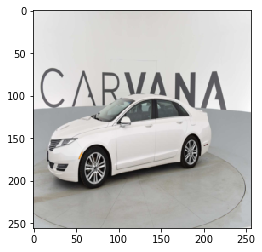

In [5]:
# example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, 5, [256, 256])
img, msk = next(train_gen)

plt.imshow(img[0])

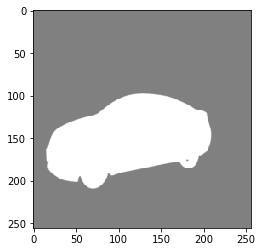

In [6]:
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [7]:
msk[0].shape

(256, 256, 1)

In [8]:
def CreateSegNet(input_shape, n_labels, kernel=3, pool_size=(2, 2), loss_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    """
    pool_1 = MaxPooling2D(pool_size)(conv_2)
    mask_1 = MaxPoolingMask2D(pool_size)(conv_2)
    """
    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)
    """
    pool_2 = MaxPooling2D(pool_size)(conv_4)
    mask_2 = MaxPoolingMask2D(pool_size)(conv_4)
    """
    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)
    """
    pool_3 = MaxPooling2D(pool_size)(conv_7)
    mask_3 = MaxPoolingMask2D(pool_size)(conv_7)
    """
    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)
    """
    pool_4 = MaxPooling2D(pool_size)(conv_10)
    mask_4 = MaxPoolingMask2D(pool_size)(conv_10)
    """
    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)
    """
    pool_5 = MaxPooling2D(pool_size)(conv_13)
    mask_5 = MaxPoolingMask2D(pool_size)(conv_13)
    """
    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build enceder done..")

    # decoder
    """
    upsample_1 = UpSampling2D(pool_size)(pool_5)
    unpool_1 = Multiply()([upsample_1, mask_5])
    """
    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)
    """
    upsample_2 = UpSampling2D(pool_size)(conv_16)
    unpool_2 = Multiply()([upsample_2, mask_4])
    """
    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)
    """
    upsample_3 = UpSampling2D(pool_size)(conv_19)
    unpool_3 = Multiply()([upsample_3, mask_3])
    """
    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)
    """
    upsample_4 = UpSampling2D(pool_size)(conv_22)
    unpool_4 = Multiply()([upsample_4, mask_2])
    """
    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)
    """
    upsample_5 = UpSampling2D(pool_size)(conv_24)
    unpool_5 = Multiply()([upsample_5, mask_1])
    """
    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    #conv_26 = Reshape((input_shape[0] * input_shape[1], n_labels), input_shape=(input_shape[0], input_shape[1], n_labels))(conv_26)
    #conv_26 = Permute((2, 1))(conv_26)
    outputs = Activation(loss_mode)(conv_26)
    print("Build decoder done..")

    segnet = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return segnet

In [9]:
segnet = CreateSegNet((256, 256, 3), 1, 3, (2, 2),loss_mode="sigmoid")

Build enceder done..
Build decoder done..


In [10]:
segnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 256, 256, 64)  256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 256, 256, 64)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [ ]:
# Now let's use Tensorflow to write our own dice_coeficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [ ]:
# Training time!
# probably need to play around a little bit with the learning rate to get it to start learning
segnet.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])
segnet.fit_generator(train_gen, steps_per_epoch=100, epochs=20)

Epoch 1/20
100/100 [==============================] - 67s - loss: 0.4608 - dice_coef: 0.8560      

In [ ]:
predicted = segnet.evaluate_generator(train_gen, steps=10)

In [ ]:
predicted

In [ ]:
segnet.save_weights("../carvana/SegNet10.hdf5")